## Functions

In [ ]:
from helpers import write_result, load_malawi_data, split_data, SAVE_PATH

from pathlib import Path
from typing import Tuple, Iterable, Dict

import pandas as pd
import numpy as np
import importlib

import seaborn as sns
sns.set_theme()

from multiprocessing import Pool

path_to_feature_sets = Path('/home/selker/eop/eop/select_predictors/2019')

from pathlib import Path
from multiprocessing import Pool

import numpy as np
import pandas as pd
from opt_targeted_transfers import (
    TargetedTransfers,
    ConditionalTargetedTransfers,
    HybridTargetedTransfers,
    UnconditionalTargetedTransfers,
    GapTargetedTransfers,
    OracleGapTargetedTransfers,
    OraclePovertyRateTargetedTransfers,
    BinaryTargetedTransfers,
    BinaryGapTargetedTransfers
)

class NNParams:

    def __init__(self, hidden_layer_size):
        self.hidden_layer_size = hidden_layer_size


def eval_and_record(
    tt: TargetedTransfers,
    Test: Tuple,
    save_path: Path,
    extra_run_labels: dict,
    run_determining_label: str
):
    
    (X_test, y_test, r_test) = Test
    res = tt.evaluate(X_test, y_test, r_test)
    write_result(
        save_path / 'simulation_results.csv',
        res,
        extra_run_labels
    )
    tt.evaluate_equity(
        X_test, y_test, r_test,
        path=save_path / f'equity_{run_determining_label}.csv'
    )

def run_continuous_gap(
        Train: Tuple,
        Test: Tuple,
        lambdas: Iterable[float],
        nn_params: NNParams = None,
        n_quantiles: int = 20,
        extra_run_labels: Dict = None,
        save_path = SAVE_PATH
):
    
    if nn_params is None: 
        nn_params = NNParams(hidden_layer_size=64)
    
    if extra_run_labels is None:
        extra_run_labels = dict()
    
    (X_train, y_train, r_train) = Train
    (X_test, y_test, r_test) = Test

    tt = GapTargetedTransfers(c_bar=2.15)
    tt.fit(
        X_train, y_train, r_train, n_quantiles=n_quantiles,
        hidden_layer_size=nn_params.hidden_layer_size
    )

    for lambda_ in lambdas:

        extra_run_labels = {
            **extra_run_labels,
            'policy_type': 'continuous_gap',
            'lambda': lambda_,
            'n_quantiles': n_quantiles,
            'hidden_layer_size': nn_params.hidden_layer_size
        }
            
        tt.run_opt(X_test, lambda_)
        eval_and_record(
            tt, Test, save_path, 
            extra_run_labels, f'cont_gap_lambda_{lambda_}'
        )

def run_binary_gap(
    Train: Tuple,
    Test: Tuple,
    budgets: Iterable[float],
    nn_params: NNParams = None,
    num_t_values: int = 20,
    extra_run_labels: Dict = None,
    save_path = SAVE_PATH
):
    
    if nn_params is None: 
        nn_params = NNParams(hidden_layer_size=64)

    if extra_run_labels is None:
        extra_run_labels = dict()

    (X_train, y_train, r_train) = Train
    (X_test, y_test, r_test) = Test

    tt = BinaryGapTargetedTransfers(
        c_bar=2.15, num_t_values=num_t_values
    )

    tt.fit(
        X_train, y_train, r_train, hidden_layer_size=nn_params.hidden_layer_size
    )
    for budget in budgets:
        tt.run_opt(X_test, r_test, budget)
        extra_run_labels = {
            **extra_run_labels,
            'budget': budget,
            't': tt.t,
            'hidden_layer_size': nn_params.hidden_layer_size
        }
        eval_and_record(
            tt, Test, save_path, extra_run_labels,
            f'binary_gap_budget_{budget}'
        )


def run_continuous_unconditional_rate_targeting(
    Train: Tuple,
    Test: Tuple,
    unconditional_tolerances: Iterable[float],
    extra_run_labels: Dict = None,
    save_path = SAVE_PATH
):
    
    (X_train, y_train, r_train) = Train
    (X_test, y_test, r_test) = Test

    if extra_run_labels is None:
        extra_run_labels = dict()

    tt = UnconditionalTargetedTransfers(c_bar=2.15)

    tt.fit(X_train, y_train, r_train)
    for tol in unconditional_tolerances:
        run_determining_string = f'uncond_cont_rate_uncondtol_{tol}'
        tt.run_opt(
            X_test, r_test, path=save_path / f'{run_determining_string}_opt.csv'
        )
        # unconditional and conditional tolerance are automatically 
        # added to results dictionary - no need to do so here.
        eval_and_record(
            tt, Test, save_path, extra_run_labels, run_determining_string
        )


def run_continuous_conditional_rate_targeting(
    Train: Tuple,
    Test: Tuple, 
    conditional_tolerances: Iterable[float],
    method: str,
    extra_run_labels: Dict = None,
    save_path = SAVE_PATH
):
        
    (X_train, y_train, r_train) = Train
    (X_test, y_test, r_test) = Test

    if extra_run_labels is None:
        extra_run_labels = dict()

    assert method in ('qr', 'density')
    tt = ConditionalTargetedTransfers(method=method, c_bar=2.15)

    if method == 'density':
        tt.fit(X_train, y_train, r_train)
    
    for tol in conditional_tolerances:
        tt.set_conditional_tolerance(tol)
        if method == 'qr':
            tt.fit(X_train, y_train, r_train)
        tt.run_opt(X_test, r_test)

        eval_and_record(
            tt, Test, save_path, extra_run_labels,
            f'cond_cont_rate_uncondtol_{tol}'
        )

def run_hyprid_rate_targeting():
    raise NotImplemented()


def run_binary_rate_targeting(
    Train,
    Test,
    unconditional_tolerances: Iterable[float],
    conditional_tolerances: Iterable[float] = None,
    extra_run_labels: Dict = None,
    save_path = SAVE_PATH
):
        
    (X_train, y_train, r_train) = Train
    (X_test, y_test, r_test) = Test

    if extra_run_labels is None:
        extra_run_labels = dict()
    
    if conditional_tolerances is None:
        conditional_tolerances = [1.]
    
    tt = BinaryTargetedTransfers(c_bar=2.15)
    tt.fit(X_train, y_train, r_train)

    for uncondtol in unconditional_tolerances:
        tt.set_unconditional_tolerance(uncondtol)

        for condtol in conditional_tolerances:
            tt.set_conditional_tolerance(condtol)
            tt.run_opt(X_test, r_test)
            eval_and_record(
                tt, Test, save_path, extra_run_labels, 
                f'binary_rate_uncondtol_{uncondtol}_condtol_{condtol}'
            )

def run_rate_targeting_grid(
    features, 
    district=None, 
    extra_run_labels=None,  # dictionary
    ds=None,  # number(s) of features to keep
    policy_types=None,  # iterable: kinds of policy
    quantile_methods=None,  # iterable
    condtols=None,  # iterable
    uncondtols=None,  # iterable
    n_cores=24,  # int: number of cores
    save=None
):
    
    assert save is not None
    args = []

    if ds is None:
        ds=[len(features)]

    for d in ds:
        features_d = features[:d]
        for policy_type in policy_types:
            if policy_type == "conditional":
                for quantile_method in quantile_methods:

                    args.append(
                        {
                            'policy_type': policy_type, 
                            'features': features_d,
                            'method': quantile_method, 
                            'condtols': condtols,
                        }
                    )

            elif policy_type == "unconditional":

                args.append(
                        {
                            'policy_type': policy_type,  
                            'features': features_d,
                            'uncondtols': uncondtols,
                        }
                )

            elif policy_type == "hybrid":
                args.append(
                        {
                            
                            'policy_type': policy_type,  
                            'features': features_d,
                            'uncondtols': uncondtols,
                            'condtols': condtols
                        }
                )
            elif policy_type == "binary":
                args.append(
                        {
                            'policy_type': policy_type,  
                            'features': features_d,
                            'uncondtols': uncondtols,
                            'condtols': condtols
                        }
                )
    for arg in args:
        arg.update(
            {
                'country': 'malawi', 
                'extra_run_labels': extra_run_labels,
                'district': district,
                'save': save
            }
        )

    if n_cores:

        pool = Pool(n_cores)
    
        pool.map_async(
            _unpack_and_run,
            args,
            error_callback=error_callback
        )
    
        pool.close()
        pool.join()

    else:

        for args_dictionary in args:
            _unpack_and_run(args_dictionary)


# wrap in a local method just in case the main functions get refactored to other files-
# they need to be serializable.
def _unpack_and_run(args_dictionary):
    return run_rate_targeting(
        **args_dictionary
    )

def error_callback(error):
    print(f"Process failed: {str(error)}")

In [1]:
from helpers import write_result, load_malawi_data, split_data, SAVE_PATH

from pathlib import Path
from typing import Tuple, Iterable

import pandas as pd
import numpy as np
import importlib

import seaborn as sns
sns.set_theme()

from multiprocessing import Pool

path_to_feature_sets = Path('/home/selker/eop/eop/select_predictors/2019')

from pathlib import Path
from multiprocessing import Pool

import numpy as np
import pandas as pd
from opt_targeted_transfers import (
    TargetedTransfers,
    ConditionalTargetedTransfers,
    HybridTargetedTransfers,
    UnconditionalTargetedTransfers,
    GapTargetedTransfers,
    OracleGapTargetedTransfers,
    OraclePovertyRateTargetedTransfers,
    BinaryTargetedTransfers,
    BinaryGapTargetedTransfers
)

def run_gap_targeting_grid(
    country="malawi",
    save="malawi_results.csv",
    features=None,
    extra_run_labels=None,
    district=None,
    ns_quantiles=[20],
    hidden_layer_sizes=[64],
    lambdas=None  # iterable
):

    save.mkdir(exist_ok=True, parents=True)

    d = len(features)
    
    if extra_run_labels is None:
        extra_run_labels = dict()

    if features is None:
        # TODO: Redo this signature
        raise ValueError('Specify some features!')

    # A semi-hack to replace the incorrect d that was populated before.
    extra_run_labels.update({'d': d})
    
    X, y, r, _ = load_malawi_data(features, district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    base_name = f'{country}_d={d}_gap'

    if lambdas is None:
        raise ValueError('need lambdas')

    tt = GapTargetedTransfers(c_bar=2.15)

    for n_quantiles in ns_quantiles:
        
        for hidden_layer_size in hidden_layer_sizes:

            tt.fit(X_train, y_train, r_train, n_quantiles=n_quantiles, hidden_layer_size=hidden_layer_size)
        
            for lambda_ in lambdas:
            
                tt.run_opt(
                    X_test,
                    lambda_
                )
                assignments = tt.opt_policy(X_test)

                res = tt.evaluate(X_test, y_test, r_test)
                write_result(
                    save / "{}.csv".format(country), 
                    res,
                    {
                        **extra_run_labels, 
                        'policy_type': 'gap',
                        'lambda': lambda_,
                        'n_quantiles': n_quantiles,
                        'hidden_layer_size': hidden_layer_size
                    }
                )
                tt.evaluate_equity(X_test, y_test, r_test, path=save / f'equity_continuous_gap_lambda_{lambda_}.csv')

    return assignments


def run_oracle_gap_targeting(
    country="malawi",
    save=None,
    uncondtols=None,
    extra_run_labels=None,
    district=None,
    schemes=None,
):
    
    if uncondtols is None:
        raise ValueError('specify tolerances')

    if schemes is None:
        raise ValueError('specify schemes')
        
    assert save is not None

    save.mkdir(exist_ok=True, parents=True)
    
    if extra_run_labels is None:
        extra_run_labels = dict()
    
    X, y, r, _ = load_malawi_data([], district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    for unconditional_tolerance in uncondtols:
        for scheme in schemes:
    
            tt = OracleGapTargetedTransfers(
                c_bar=2.15, scheme=scheme, unconditional_tolerance=unconditional_tolerance
            )
        
            tt.run_opt(
                y_test, r_test
            )
            res = tt.evaluate(X_test, y_test, r_test)

            write_result(
                save / "{}.csv".format(country), 
                res,
                {
                    **extra_run_labels, 
                    'policy_type': 'oracle_gap',
                    'oracle_gap_scheme': scheme
                }
            )
            tt.evaluate_equity(X_test, y_test, r_test, path=save / f'equity_oracle_gap_uncondtol_{unconditional_tolerance}_scheme_{scheme}.csv')


def run_binary_gap_targeting_grid(
    country="malawi",
    save="malawi_results.csv",
    features=None,
    extra_run_labels=None,
    district=None,
    budgets=None,
    hidden_layer_sizes=[64],
    num_t_values=20
):
    if budgets is None:
        raise ValueError('specify budgets')
    assert save is not None
    save.mkdir(exist_ok=True, parents=True)
    
    if extra_run_labels is None:
        extra_run_labels = dict()
    
    X, y, r, _ = load_malawi_data(features, district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    for hidden_layer_size in hidden_layer_sizes:

        tt = BinaryGapTargetedTransfers(c_bar=2.15, num_t_values=num_t_values)
        tt.fit(X_train, y_train, r_train, hidden_layer_size=hidden_layer_size)
        tt.optimize_transfers_for_budget_grid(X_test, r_test, budgets)
        
        for budget in budgets:
            tt.run_opt(X_test, r_test, budget)

            res = tt.evaluate(X_test, y_test, r_test)
            write_result(
                save / "{}.csv".format(country), 
                res,
                {
                    **extra_run_labels, 
                    'policy_type': 'binary_gap',
                    'budget': budget,
                    'hidden_layer_size': hidden_layer_size,
                    't': tt.t
                }
            )

            tt.evaluate_equity(X_test, y_test, r_test, path=save / f'equity_binary_gap_budget_{budget}.csv')
        

def run_oracle_rate_targeting(
    country='malawi',
    uncondtols=None,  # iterable
    save=None,
    district=None,
    extra_run_labels=None
):
    if uncondtols is None:
        raise ValueError('specify tolerances')
        
    assert save is not None

    save.mkdir(exist_ok=True, parents=True)
    
    if extra_run_labels is None:
        extra_run_labels = dict()
    
    X, y, r, _ = load_malawi_data([], district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    for unconditional_tolerance in uncondtols:    
        tt = OraclePovertyRateTargetedTransfers(
            c_bar=2.15, unconditional_tolerance=unconditional_tolerance
        )
    
        tt.run_opt(
            y_test, r_test
        )
        res = tt.evaluate(X_test, y_test, r_test)

        write_result(
            save / "{}.csv".format(country), 
            res,
            {
                **extra_run_labels, 
                'policy_type': 'oracle_rate',
            }
        )   
        tt.evaluate_equity(X_test, y_test, r_test, path=save / f'equity_oracle_rate_uncondtol_{unconditional_tolerance}.csv')


def run_rate_targeting(
    country="malawi",
    policy_type="unconditional",
    method="qr",
    condtols=None,  # iterable
    uncondtols=None,  # iterable
    save=None,
    features=None,
    extra_run_labels=None,
    district=None
):

    assert save is not None
    save.mkdir(exist_ok=True, parents=True)

    d = len(features)
    
    if extra_run_labels is None:
        extra_run_labels = dict()

    if features is None:
        raise ValueError('Specify some features!')

    # A semi-hack to replace the incorrect d that was populated before.
    extra_run_labels.update({'d': d})
    
    X, y, r, _ = load_malawi_data(features, district)

    
    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    base_name = f'{country}_d={d}_{policy_type}'

    if policy_type == "unconditional":

        tt = UnconditionalTargetedTransfers(c_bar=2.15)
        
        tt.fit(X_train, y_train, r_train)
        for tol in uncondtols:
            tt.set_unconditional_tolerance(tol)
            tt.run_opt(
                    X_test,
                    r_test,
                    path=save / f'{base_name}_uncondtol={tol}_opt.csv'
                )
            res = tt.evaluate(X_test, y_test, r_test)
            write_result(save / "{}.csv".format(country), res, extra_run_labels)
            tt.evaluate_equity(
                X_test,
                y_test,
                path=save / f'equity_{base_name}_uncondtol={tol}_opt.csv'
            )

    elif policy_type == "conditional":
        tt = ConditionalTargetedTransfers(method=method, c_bar=2.15)

        if method == "density":
            tt.fit(X_train, y_train, r_train)
            for tol in condtols:
                tt.set_conditional_tolerance(tol)
                tt.run_opt(
                        X_test,
                        r_test,
                    )
                res = tt.evaluate(X_test, y_test, r_test)
                print('saving')
                write_result(save / f'{country}.csv', res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_undcondtol={tol}_condtol={tol}'
                )
        elif method == "qr":
            for tol in condtols:
                tt.set_conditional_tolerance(tol)
                tt.fit(X_train, y_train, r_train)
                tt.run_opt(
                        X_test,
                        r_test,
                    )
                res = tt.evaluate(X_test, y_test, r_test)
                write_result(save / f'{country}.csv', res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_uncondtol={tol}_condtol={tol}.csv'
                )

    elif policy_type == "hybrid":

        tt = HybridTargetedTransfers(c_bar=2.15)
        tt.fit(X_train, y_train, r_train)
        
        for tol1 in uncondtols:
            for tol2 in condtols:
                tt.set_conditional_tolerance(tol2)
                tt.set_unconditional_tolerance(tol1)
                tt.run_opt(
                    X_test,
                    r_test,
                    path=save / f'{base_name}_uncondtol={tol1}_condtol={tol2}_opt.csv'
                )
                res = tt.evaluate(X_test, y_test, r_test)
                write_result(save / "{}.csv".format(country), res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_uncondtol={tol1}_condtol={tol2}.csv'
                )
    elif policy_type == "binary":
        tt = BinaryTargetedTransfers(c_bar=2.15)
        tt.fit(X_train, y_train, r_train)

        for tol1 in uncondtols:
            if condtols is None:
                condtols = [1.0]
            for tol2 in condtols:
                tt.set_conditional_tolerance(tol2)
                tt.set_unconditional_tolerance(tol1)
                tt.run_opt(X_test=X_test, r_test=r_test)
                res = tt.evaluate(X_test, y_test, r_test)
                write_result(save / "{}.csv".format(country), res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_uncondtol={tol1}_condtol={tol2}_opt.csv'
                )

def run_rate_targeting_grid(
    features, 
    district=None, 
    extra_run_labels=None,  # dictionary
    ds=None,  # number(s) of features to keep
    policy_types=None,  # iterable: kinds of policy
    quantile_methods=None,  # iterable
    condtols=None,  # iterable
    uncondtols=None,  # iterable
    n_cores=24,  # int: number of cores
    save=None
):
    
    assert save is not None
    args = []

    if ds is None:
        ds=[len(features)]

    for d in ds:
        features_d = features[:d]
        for policy_type in policy_types:
            if policy_type == "conditional":
                for quantile_method in quantile_methods:

                    args.append(
                        {
                            'policy_type': policy_type, 
                            'features': features_d,
                            'method': quantile_method, 
                            'condtols': condtols,
                        }
                    )

            elif policy_type == "unconditional":

                args.append(
                        {
                            'policy_type': policy_type,  
                            'features': features_d,
                            'uncondtols': uncondtols,
                        }
                )

            elif policy_type == "hybrid":
                args.append(
                        {
                            
                            'policy_type': policy_type,  
                            'features': features_d,
                            'uncondtols': uncondtols,
                            'condtols': condtols
                        }
                )
            elif policy_type == "binary":
                args.append(
                        {
                            'policy_type': policy_type,  
                            'features': features_d,
                            'uncondtols': uncondtols,
                            'condtols': condtols
                        }
                )
    for arg in args:
        arg.update(
            {
                'country': 'malawi', 
                'extra_run_labels': extra_run_labels,
                'district': district,
                'save': save
            }
        )

    if n_cores:

        pool = Pool(n_cores)
    
        pool.map_async(
            _unpack_and_run,
            args,
            error_callback=error_callback
        )
    
        pool.close()
        pool.join()

    else:

        for args_dictionary in args:
            _unpack_and_run(args_dictionary)


# wrap in a local method just in case the main functions get refactored to other files-
# they need to be serializable.
def _unpack_and_run(args_dictionary):
    return run_rate_targeting(
        **args_dictionary
    )

def error_callback(error):
    print(f"Process failed: {str(error)}")

## Rate targeting

### Subnational analysis

In [13]:
%%time

for covariates_file in list((path_to_feature_sets / 'district_level_covariates').iterdir()):
    covariates = pd.read_csv(covariates_file)
    district = covariates_file.stem
    malawi_runs(
        covariates.covariate.values,
        district,
        extra_run_labels={
            'features': f'{district}',
            'with_weights': True
        }
    )

NameError: name 'malawi_runs' is not defined

In [14]:
full_country_covariates = pd.read_csv(path_to_feature_sets / 'covariates_below_5_durable.csv').covariate.values
# full_country_covariates = pd.read_csv(path_to_feature_sets / 'covariates_country_all.csv').covariate.values

run_rate_targeting_grid(
    full_country_covariates,
    n_cores=False,
    extra_run_labels = {
        'features': 'full_country',
        'with_weights': True
    }
)

AssertionError: 

## Gap targeting

In [15]:
selected_durable_verifiable_covariates = pd.read_csv(path_to_feature_sets / 'covariates_below_5_durable.csv').covariate.values
full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values
mosaiks_nearest_features = pd.read_csv(
    path_to_feature_sets / 'mosaiks_nearest_features.csv'
).covariate.values

non_linear_lambdas = np.concatenate((np.linspace(0, .15, 20, endpoint=False) ,np.linspace(.15, 1, 20)))
non_linear_lambdas.sort()

### Gap targeting

In [ ]:
run_oracle_gap_targeting(
    country="malawi",
    save=SAVE_PATH / 'oracle_gap',
    extra_run_labels=None,
    schemes=['lift_to_line'],
    uncondtols=np.linspace(0, .5, 20)
)

In [16]:
run_gap_targeting_grid(
    features=selected_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'selected_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 220.69it/s, val loss=1.57e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 280.59it/s, val loss=0.0378]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 278.20it/s, val loss=0.0556]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 270.27it/s, val loss=0.0649]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 269.70it/s, val loss=0.0713]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 213.29it/s, val loss=0.0721]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 240.27it/s, val loss=0.066] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 268.68it/s, val loss=0.0554]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 242.38it/s, val loss=0.0361]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 239.74it/s, val loss=7.7e-6] 


{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [19]:
run_gap_targeting_grid(
    features=selected_durable_verifiable_covariates[:4],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': '4_selected_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 221.71it/s, val loss=0]      


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 277.68it/s, val loss=0.0356]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 292.75it/s, val loss=0.0567]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 289.19it/s, val loss=0.0694]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:00<00:00, 309.31it/s, val loss=0.0748]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 274.29it/s, val loss=0.0749]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 269.29it/s, val loss=0.0699]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 276.59it/s, val loss=0.0568]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 269.72it/s, val loss=0.0365]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 270.55it/s, val loss=0]      


{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [21]:
run_gap_targeting_grid(
    features=[],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'None'}
)

/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f7ef40461f0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f7ef40461f0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f7ef40461f0> is currently using DataFrameGroupBy.sum. In a future version of pand

{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [17]:
run_gap_targeting_grid(
    features=mosaiks_nearest_features,
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'mosaiks'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:05<00:00, 53.04it/s, val loss=1.31e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:04<00:00, 62.54it/s, val loss=0.0529]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:04<00:00, 62.75it/s, val loss=0.0809]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:04<00:00, 62.19it/s, val loss=0.0976]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:06<00:00, 49.35it/s, val loss=0.108]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:05<00:00, 50.54it/s, val loss=0.11] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:06<00:00, 49.49it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:04<00:00, 63.36it/s, val loss=0.0915]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:06<00:00, 47.21it/s, val loss=0.0612]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:06<00:00, 47.53it/s, val loss=0.000464]
/home/selker/eop/poverty/package/src/opt_targeted_transfers/quantile_regression.py:110: RuntimeWarning: overflow encountered in exp
  return np.maximum(np.exp(quantile), 0)


{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [13]:
run_gap_targeting_grid(
    features=['district'],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'district'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 284.15it/s, val loss=0.000125]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 306.69it/s, val loss=0.0435]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 304.82it/s, val loss=0.0704]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 307.12it/s, val loss=0.089]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 302.49it/s, val loss=0.102]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 302.07it/s, val loss=0.107]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 303.37it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 301.61it/s, val loss=0.0974]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 302.49it/s, val loss=0.0813]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 304.44it/s, val loss=0.0538]


In [14]:
run_gap_targeting_grid(
    features=['ea_id'],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'EA'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 156.14it/s, val loss=0.00267]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 171.58it/s, val loss=0.0503]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 174.57it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 181.48it/s, val loss=0.0918]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 181.12it/s, val loss=0.103]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 181.24it/s, val loss=0.109]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 180.20it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 180.52it/s, val loss=0.0996]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 174.58it/s, val loss=0.0831]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 173.70it/s, val loss=0.0568]


In [18]:
run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 187.95it/s, val loss=2.67e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 221.36it/s, val loss=0.0426]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 201.13it/s, val loss=0.0612]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 207.49it/s, val loss=0.0688]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 219.41it/s, val loss=0.0961]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 222.27it/s, val loss=0.0995]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 218.87it/s, val loss=0.0931]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 205.08it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 217.95it/s, val loss=0.0478]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 209.28it/s, val loss=0]     


{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [15]:
run_gap_targeting_grid(
    features=np.concatenate((full_set_durable_verifiable_covariates, mosaiks_nearest_features)),
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'mosaiks_and_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 61.05it/s, val loss=0.000192]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 44.90it/s, val loss=0.0527]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 48.20it/s, val loss=0.0748]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 50.69it/s, val loss=0.0645]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 46.97it/s, val loss=0.0691]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 50.38it/s, val loss=0.0681]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 54.28it/s, val loss=0.0727]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 60.60it/s, val loss=0.066]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 57.56it/s, val loss=0.0595]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 57.98it/s, val loss=0.037]


In [21]:
run_gap_targeting_grid(
    features=[],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'mosaiks_and_durable'}
)

/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f27d00f4430> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f27d00f4430> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f27d00f4430> is currently using DataFrameGroupBy.sum. In a future version of pand

### Parameter search

In [ ]:
run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5,10,20,50],
    extra_run_labels={'features': 'all_durable'}
)

In [ ]:
run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5, 20],
    hidden_layer_sizes=[4096],
    extra_run_labels={'features': 'all_durable'}
)

In [ ]:
run_gap_targeting_grid(
    features=mosaiks_nearest_features,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5, 20],
    hidden_layer_sizes=[64, 128, 256, 512],
    extra_run_labels={'features': 'mosaiks'}
)

In [47]:
run_gap_targeting_grid(
    features=mosaiks_nearest_features,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5],
    hidden_layer_sizes=[4096],
    extra_run_labels={'features': 'mosaiks'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.78it/s, val loss=0]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.33it/s, val loss=0.0731]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.46it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.29it/s, val loss=0.109]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.25it/s, val loss=0.086]


### Rate targeting for comparison

In [ ]:
uncondtols = np.linspace(0.01, 0.6, 20)
run_rate_targeting(
    country='malawi',
    policy_type='unconditional',
    uncondtols=uncondtols,
    save=SAVE_PATH / 'rate_for_gap_comparison',
    features=selected_durable_verifiable_covariates
)

### With and without TA

In [10]:
full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values

# Parameters selected for gap targeting above
n_quantiles = 10
hidden_layer_size = 64

# lambdas for good coverage
non_linear_lambdas = np.concatenate((np.linspace(0, .15, 20, endpoint=False) ,np.linspace(.15, 1, 20)))
non_linear_lambdas.sort()

In [13]:
assignments = run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH  / 'gap_with_and_without_TA',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 173.21it/s, val loss=2.67e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 207.79it/s, val loss=0.0426]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 206.03it/s, val loss=0.0612]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 206.06it/s, val loss=0.0688]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 204.99it/s, val loss=0.0961]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 193.59it/s, val loss=0.0995]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 192.44it/s, val loss=0.0931]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 187.57it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 208.57it/s, val loss=0.0478]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 204.50it/s, val loss=0]


In [14]:
assignments = run_gap_targeting_grid(
    features=np.concatenate((full_set_durable_verifiable_covariates,  ['TA'])),
    country='malawi',
    save=SAVE_PATH  / 'gap_with_and_without_TA',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable_plus_TA'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 171.18it/s, val loss=0.000153]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 205.25it/s, val loss=0.0394]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 204.68it/s, val loss=0.0587]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 198.48it/s, val loss=0.0699]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 190.93it/s, val loss=0.0763]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 197.30it/s, val loss=0.104]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 194.32it/s, val loss=0.102]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 203.87it/s, val loss=0.0787]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 200.51it/s, val loss=0.0511]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 200.16it/s, val loss=0]


### Checking quantile regression

In [3]:
import seaborn as sns
sns.set_theme()

full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values

X, y, r, _ = load_malawi_data(full_set_durable_verifiable_covariates)

(X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
    X=X, y=y, r=r, p=0.6, random_seed=123
)

tt = GapTargetedTransfers(c_bar=2.15)

test_quantile_rates = []
train_quantile_rates = []
for hidden_layer_size in [64, 512]:
    for n_quantiles in [20]:
        
        (quantiles, quantile_regressors, dataset) = tt.fit(
            X_train, y_train,  n_quantiles=n_quantiles, hidden_layer_size=hidden_layer_size
        )
        
        test_quantile_outcomes = []
        train_quantile_outcomes = []
        quantiles_to_try = np.linspace(0, .4, 25)
        for quantile in quantiles_to_try:
        
            estimated_quantile_wealth_levels = tt._get_baseline_wealth_at_quantile(X_test, quantile, quantile_regressors)
            test_quantile_outcomes.append(y_test.flatten() < estimated_quantile_wealth_levels.flatten())

            estimated_quantile_wealth_levels = tt._get_baseline_wealth_at_quantile(X_train, quantile, quantile_regressors)
            train_quantile_outcomes.append(y_train.flatten() < estimated_quantile_wealth_levels.flatten())
        
        test_quantile_outcomes = np.array(test_quantile_outcomes)
        train_quantile_outcomes = np.array(train_quantile_outcomes)
        
        test_quantile_indicators = pd.DataFrame(columns=quantiles_to_try, data=test_quantile_outcomes.transpose()).astype(int)
        test_quantile_rates_this_run = test_quantile_indicators.mean().to_frame()
        test_quantile_rates_this_run.reset_index(inplace=True)
        test_quantile_rates_this_run.columns=['quantile', 'actual_below_estimated']
        test_quantile_rates_this_run['n_quantiles'] = n_quantiles
        test_quantile_rates_this_run['hidden_layer_size'] = hidden_layer_size
        test_quantile_rates.append(test_quantile_rates_this_run)

        train_quantile_indicators = pd.DataFrame(columns=quantiles_to_try, data=train_quantile_outcomes.transpose()).astype(int)
        train_quantile_rates_this_run = train_quantile_indicators.mean().to_frame()
        train_quantile_rates_this_run.reset_index(inplace=True)
        train_quantile_rates_this_run.columns=['quantile', 'actual_below_estimated']
        train_quantile_rates_this_run['n_quantiles'] = n_quantiles
        train_quantile_rates_this_run['hidden_layer_size'] = hidden_layer_size
        train_quantile_rates.append(train_quantile_rates_this_run)

test_quantile_rates = pd.concat(test_quantile_rates)
train_quantile_rates = pd.concat(train_quantile_rates)

test_quantile_rates['dataset'] = 'test'
train_quantile_rates['dataset'] = 'train'

quantile_rates = pd.concat((test_quantile_rates, train_quantile_rates))

to_plot = quantile_rates[quantile_rates.dataset=='test']
fg = sns.relplot(
    data=to_plot, x='quantile', y='actual_below_estimated', hue='n_quantiles', 
    style='hidden_layer_size', kind='line',
    legend=True, aspect=12/8, height=8
)
for ax in fg.figure.axes:
    
    sns.lineplot(
        data=to_plot,
        x='quantile', y='quantile',
        color='red',
        linestyle='--',
        label='x=y',
        ax=ax,
        legend=True
    )
fg.set(xlabel='Quantile', ylabel='Fraction below estimated quantile wealth (OOS)')

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 107.98it/s, val loss=0]     


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 125.38it/s, val loss=0.0235]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 110.37it/s, val loss=0.0373]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 106.95it/s, val loss=0.0509]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 105.24it/s, val loss=0.059] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 126.53it/s, val loss=0.0644]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 143.92it/s, val loss=0.0679]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 141.40it/s, val loss=0.0744]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 142.41it/s, val loss=0.0888]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 130.84it/s, val loss=0.106] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 100.07it/s, val loss=0.106] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 127.12it/s, val loss=0.106] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 135.36it/s, val loss=0.114] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 148.08it/s, val loss=0.104] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 140.79it/s, val loss=0.0916]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 138.57it/s, val loss=0.0802]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 137.74it/s, val loss=0.0681]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 140.42it/s, val loss=0.0493]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 142.60it/s, val loss=0.0321]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 149.20it/s, val loss=0.000134]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 117.10it/s, val loss=0]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 122.23it/s, val loss=0.0247]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 122.35it/s, val loss=0.0405]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 116.75it/s, val loss=0.0533]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 129.87it/s, val loss=0.0634]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 116.22it/s, val loss=0.0639]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 123.54it/s, val loss=0.074] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 124.26it/s, val loss=0.0779]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 118.22it/s, val loss=0.0877]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 121.36it/s, val loss=0.0928]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 126.18it/s, val loss=0.102] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 124.98it/s, val loss=0.119] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 121.97it/s, val loss=0.109] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 122.45it/s, val loss=0.1]   


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 116.41it/s, val loss=0.0976]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 122.09it/s, val loss=0.0844]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 123.11it/s, val loss=0.0728]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 120.38it/s, val loss=0.056] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 119.04it/s, val loss=0.0322]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 115.85it/s, val loss=0]


## Clear runs from results

In [29]:
results_path = SAVE_PATH / 'gap' / 'malawi.csv'
results = pd.read_csv(results_path)

In [31]:
results[results.d != 0].to_csv(results_path, index=False)

## Runs for top-line plots

### Setup

In [2]:
selected_durable_verifiable_covariates = pd.read_csv(path_to_feature_sets / 'covariates_below_5_durable.csv').covariate.values
full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values
mosaiks_nearest_features = pd.read_csv(
    path_to_feature_sets / 'mosaiks_nearest_features.csv'
).covariate.values

# Parameters selected for gap targeting above
n_quantiles = 10
hidden_layer_size = 64

# lambdas for good coverage
non_linear_lambdas = np.concatenate((np.linspace(0, .15, 20, endpoint=False) ,np.linspace(.15, 1, 20)))
non_linear_lambdas.sort()

uncondtols = np.concatenate((
    np.linspace(0, 0.6, 20),
    np.linspace(0, 0.15, 10)
))
uncondtols.sort()


### Continuous unconditional rate

In [ ]:
run_rate_targeting_grid(
    policy_types=['unconditional'],
    features=selected_durable_verifiable_covariates,
    n_cores=32,
    district=None,
    ds=None,
    uncondtols=uncondtols,
    extra_run_labels = {
        'features': 'top 30 covariates',
        'with_weights': True,
    },
    save=SAVE_PATH / 'top_line' /  'continuous_unconditional_rate'
)

In [ ]:
run_rate_targeting_grid(
    policy_types=['unconditional'],
    features=selected_durable_verifiable_covariates[:3],
    n_cores=32,
    district=None,
    ds=None,
    uncondtols=uncondtols[19:],
    extra_run_labels = {
        'features': 'top 3 covariates',
        'with_weights': True,
    },
    save=SAVE_PATH / 'top_line' / 'continuous_unconditional_rate_3_covariates'
)

KNOTS:[-3.19285878 -3.19285878 -3.19285878 -3.19285878 -1.19913911 -0.83291286
 -0.3092615   0.15344965  4.95174501  4.95174501  4.95174501  4.95174501]
Fitting conditional densities vs glm spline method...


100%|██████████| 300/300 [02:57<00:00,  1.69it/s, loss=-0.0961, val_loss=-0.0775]


Final Theta: tensor([[ 0.2833,  0.3620, -0.3524,  1.1966, -0.6737,  0.0203,  0.4933,  1.2706,
         -0.5850, -0.0070],
        [ 0.7274, -0.7844, -0.1527,  0.7293,  0.2313,  0.5292,  0.4592,  1.5549,
          0.5924, -1.0254],
        [ 1.3429, -0.4830, -0.9041,  0.3573, -0.2274,  0.0295,  1.2652,  0.5750,
         -0.0203,  1.5057],
        [ 0.7460, -0.9788,  0.1588,  1.0956, -0.0168,  0.4284,  0.4133,  0.8607,
          0.5663,  0.3157],
        [ 0.6031,  0.0087, -0.3465,  0.5908, -0.1771, -0.3364, -1.4459, -1.5897,
          0.3175, -1.8747],
        [-1.6919,  1.2995, -0.3611, -0.6389, -0.6246,  0.2890,  0.0488,  0.2017,
          0.0467, -0.0756],
        [-0.6894,  0.6230, -0.5070, -1.1578,  0.0431,  0.0734,  1.1723,  1.2892,
         -0.5944,  0.3221],
        [-0.0536,  0.8503, -1.1465,  0.0051, -1.4480,  0.6255,  1.3466,  0.4431,
         -0.5719,  0.6412]], dtype=torch.float64)
Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [02:52<00:00,  1.16it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [02:52<00:00,  1.16it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [02:51<00:00,  1.16it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [02:55<00:00,  1.14it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [02:06<00:00,  1.59it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [02:48<00:00,  1.18it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Alpha range: 0.0011085202124299293, 1.1085202124299294


100%|██████████| 200/200 [01:15<00:00,  2.66it/s]


### Continuous gap

In [17]:
assignments = run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'top_line' / 'continuous_gap',
    lambdas=[0.01],
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 197.44it/s, val loss=2.67e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 232.02it/s, val loss=0.0426]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 233.78it/s, val loss=0.0612]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 232.94it/s, val loss=0.0688]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 231.22it/s, val loss=0.0961]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 230.76it/s, val loss=0.0995]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 230.46it/s, val loss=0.0931]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 227.56it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 225.80it/s, val loss=0.0478]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 226.14it/s, val loss=0]     


### Oracle gap

In [5]:
run_oracle_gap_targeting(
    country="malawi",
    save=SAVE_PATH / 'top_line' / 'oracle_gap',
    extra_run_labels=None,
    schemes=['lift_to_line'],
    uncondtols=uncondtols
)

### Oracle rate

In [10]:
run_oracle_rate_targeting(
    country='malawi',
    uncondtols=uncondtols,
    save=SAVE_PATH / 'top_line' / 'oracle_rate',
)

### Binary rate

In [ ]:
run_rate_targeting_grid(
    policy_types=['binary'],
    features=selected_durable_verifiable_covariates,
    n_cores=32,
    district=None,
    ds=None,
    uncondtols=uncondtols,
    extra_run_labels = {
        'features': 'top 30 covariates',
        'with_weights': True,
    },
    save=SAVE_PATH / 'top_line'  / 'binary_unconditional_rate'
)

KNOTS:[-3.19285878 -3.19285878 -3.19285878 -3.19285878 -1.19913911 -0.83291286
 -0.3092615   0.15344965  4.95174501  4.95174501  4.95174501  4.95174501]
Fitting conditional densities vs glm spline method...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 42.48it/s, loss=-0.176, val_loss=-0.101]


Final Theta: tensor([[ 1.6042e-01,  8.1857e-01, -3.0482e-01,  4.4348e-01,  1.2425e-01,
          1.7257e-01,  5.0815e-01,  1.4947e+00, -4.6805e-01, -5.9504e-02,
          2.5173e-01,  7.7788e-01, -2.3198e-01,  3.7891e-01,  3.4500e-01,
         -8.3537e-02, -5.3120e-01,  1.8449e-01,  1.5662e-01, -6.2119e-03,
          4.7108e-01, -2.3884e-01, -2.5670e-01,  5.3090e-01,  3.7913e-01,
         -6.2710e-01,  2.4005e-01,  4.7432e-02,  1.2146e-02,  5.6296e-01,
          4.6161e-01, -7.6893e-02,  9.1672e-01,  1.8175e-02, -3.9315e-01,
          2.8319e-01, -4.4846e-01,  2.7439e-01,  2.2089e-01, -1.0564e-01,
         -5.5436e-02,  2.1437e-01, -2.5737e-01, -2.6295e-03, -3.4448e-01,
          5.4245e-01,  2.9577e-01,  6.5249e-02,  5.3668e-01, -1.8981e-01,
         -2.7353e-01, -8.0393e-02, -3.5919e-01,  3.1319e-01, -1.0515e+00,
          3.6474e-01,  3.1668e-01,  2.7411e-01, -1.2127e-01,  2.9874e-01,
          7.5699e-01,  2.2727e-01,  2.8019e-01, -1.0023e-01,  3.0240e-01,
         -1.5967e-01,  7.

### Binary gap

In [ ]:
run_binary_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH /  'top_line' / 'binary_gap',
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'},
    budgets=np.linspace(0, 2.15, 20)
)

### Joining results

In [15]:
binary_gap = pd.read_csv(SAVE_PATH  / 'top_line' / 'binary_gap' / 'malawi.csv')

binary_unconditional_rate = pd.read_csv(SAVE_PATH / 'top_line' / 'binary_unconditional_rate' / 'malawi.csv')
binary_unconditional_rate['policy_type'] = 'binary_unconditional_rate'

continuous_gap = pd.read_csv(SAVE_PATH / 'top_line' / 'continuous_gap' / 'malawi.csv')
continuous_gap.policy_type = 'continuous_gap'

continuous_unconditional_rate = pd.read_csv(SAVE_PATH / 'top_line' / 'continuous_unconditional_rate' / 'malawi.csv')
continuous_unconditional_rate['policy_type'] = 'continuous_unconditional_rate'
continuous_unconditional_rate.drop(columns='method', inplace=True)
continuous_unconditional_rate = (
    continuous_unconditional_rate[continuous_unconditional_rate.features != 'gap (30 covariates)']
)
oracle_gap = pd.read_csv(SAVE_PATH / 'top_line' / 'oracle_gap' / 'malawi.csv')
oracle_rate = pd.read_csv(SAVE_PATH / 'top_line' / 'oracle_rate' / 'malawi.csv')


In [16]:
all_results = pd.concat((
    binary_gap, binary_unconditional_rate, continuous_gap, continuous_unconditional_rate, oracle_gap, oracle_rate
))

In [17]:
all_results.drop_duplicates(
    subset=[
        'policy_type', 'unconditional_tolerance', 'conditional_tolerance', 'features', 
        'lambda', 'oracle_gap_scheme', 'budget'
    ], inplace=True
)
all_results.drop(
    columns=[
        'oracle_gap_scheme', 'hidden_layer_size', 't', 'with_weights', 
        'lambda', 'n_quantiles', 'nclass', 'd'
    ], inplace=True
)

/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarn

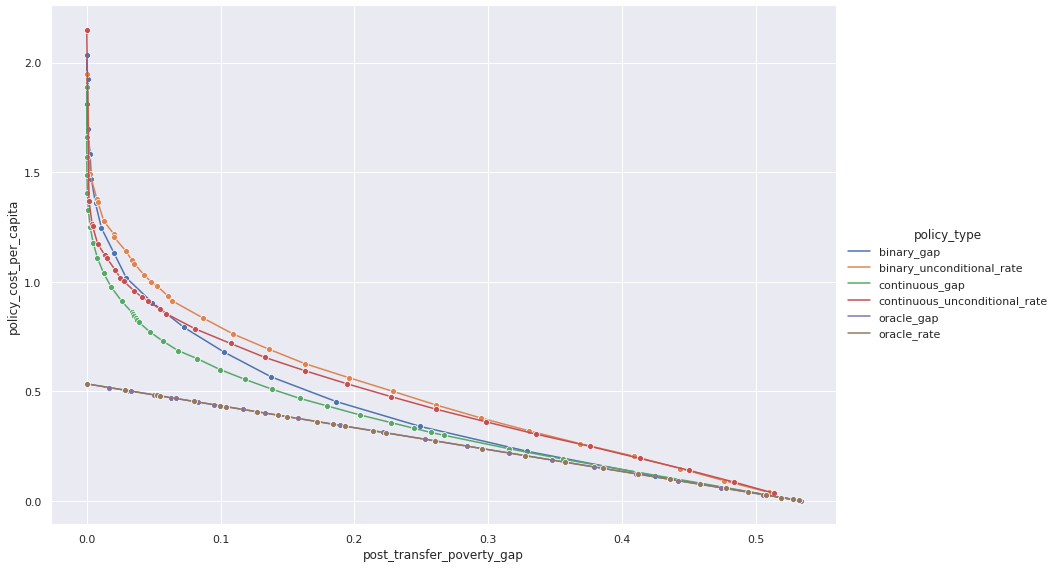

In [18]:
sns.relplot(
    data=all_results,
    x='post_transfer_poverty_gap', y='policy_cost_per_capita', hue='policy_type',kind='line',
    marker='o', height=8, aspect=12/8
)

In [19]:
all_results.to_csv(SAVE_PATH / 'manually_merged' / 'malawi.csv', index=False)

## Binary gap investigation

In [2]:

full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values

run_binary_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH  / 'binary_gap',
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'},
    budgets= np.linspace(0, 2.15, 20),
    num_t_values=20
)

val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 0.0


100%|██████████| 300/300 [01:28<00:00,  3.39it/s, val loss=0.000132]


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 0.1131578947368421


100%|██████████| 300/300 [01:19<00:00,  3.78it/s, val loss=1.71] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 0.2263157894736842


100%|██████████| 300/300 [00:02<00:00, 128.76it/s, val loss=1.46] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 0.33947368421052626


100%|██████████| 300/300 [00:01<00:00, 161.10it/s, val loss=1.51] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 0.4526315789473684


100%|██████████| 300/300 [00:01<00:00, 152.32it/s, val loss=1.43] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 0.5657894736842105


100%|██████████| 300/300 [00:01<00:00, 155.54it/s, val loss=2.85] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 0.6789473684210525


100%|██████████| 300/300 [00:01<00:00, 176.07it/s, val loss=4.47] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 0.7921052631578946


100%|██████████| 300/300 [00:01<00:00, 176.15it/s, val loss=3.5]  


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 0.9052631578947368


100%|██████████| 300/300 [00:01<00:00, 188.80it/s, val loss=3.45] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 1.018421052631579


100%|██████████| 300/300 [00:01<00:00, 196.18it/s, val loss=3.06] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 1.131578947368421


100%|██████████| 300/300 [00:01<00:00, 192.27it/s, val loss=2.13] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 1.2447368421052631


100%|██████████| 300/300 [00:01<00:00, 189.65it/s, val loss=2.75] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 1.357894736842105


100%|██████████| 300/300 [00:01<00:00, 178.75it/s, val loss=3.05] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 1.4710526315789472


100%|██████████| 300/300 [00:01<00:00, 195.07it/s, val loss=3.4]  


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 1.5842105263157893


100%|██████████| 300/300 [00:01<00:00, 210.45it/s, val loss=3.57] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 1.6973684210526314


100%|██████████| 300/300 [00:01<00:00, 206.53it/s, val loss=2.58] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 1.8105263157894735


100%|██████████| 300/300 [00:06<00:00, 43.40it/s, val loss=2.87]  


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 1.9236842105263157


100%|██████████| 300/300 [01:40<00:00,  2.99it/s, val loss=3.24] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 2.036842105263158


100%|██████████| 300/300 [01:40<00:00,  2.97it/s, val loss=2.47] 


val weight sum: 0.30234419305385885
Fitting estimator for household benefit from transfer of size 2.15


100%|██████████| 300/300 [01:40<00:00,  2.99it/s, val loss=2.47] 


In [2]:
full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values
features=full_set_durable_verifiable_covariates
country='malawi'
save=SAVE_PATH  / 'binary_gap'
extra_run_labels={'features': 'all_durable'}
budgets=[1]
num_t_values=20

if budgets is None:
    raise ValueError('specify budgets')
assert save is not None
save.mkdir(exist_ok=True, parents=True)

if extra_run_labels is None:
    extra_run_labels = dict()

X, y, r, _ = load_malawi_data(features, None)
r = r / r.sum()

(X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
    X=X, y=y, r=r, p=0.6
)

tt = BinaryGapTargetedTransfers(c_bar=2.15, num_t_values=num_t_values)
val_losses, models, estimator = tt._fit_household_benefit_estimator(
    X_train, y_train, r_train, t=1, lr=5e-3
)

in_sample_estimates = estimator(X_train)

0.6066288050879838
Fitting estimator for household benefit from transfer of size 1


  0%|          | 0/300 [00:00<?, ?it/s]

predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  0%|          | 1/300 [00:00<02:22,  2.10it/s, val loss=0.201]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  1%|          | 3/300 [00:01<01:34,  3.14it/s, val loss=0.201]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  1%|▏         | 4/300 [00:01<01:30,  3.26it/s, val loss=0.201]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  2%|▏         | 6/300 [00:01<01:00,  4.88it/s, val loss=0.201]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  2%|▏         | 7/300 [00:01<01:04,  4.54it/s, val loss=0.201]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  3%|▎         | 8/300 [00:02<01:07,  4.33it/s, val loss=0.201]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  3%|▎         | 9/300 [00:02<01:12,  4.03it/s, val loss=0.201]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  4%|▎         | 11/300 [00:02<01:03,  4.56it/s, val loss=0.124]

predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  4%|▍         | 12/300 [00:02<01:05,  4.43it/s, val loss=0.124]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  4%|▍         | 13/300 [00:03<01:11,  4.02it/s, val loss=0.124]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  5%|▍         | 14/300 [00:03<01:13,  3.90it/s, val loss=0.124]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  5%|▌         | 15/300 [00:03<01:08,  4.14it/s, val loss=0.124]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  5%|▌         | 16/300 [00:04<01:00,  4.71it/s, val loss=0.124]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  6%|▌         | 18/300 [00:04<01:04,  4.38it/s, val loss=0.124]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  6%|▋         | 19/300 [00:04<01:07,  4.18it/s, val loss=0.124]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  7%|▋         | 20/300 [00:04<01:13,  3.79it/s, val loss=0.124]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  7%|▋         | 21/300 [00:05<01:26,  3.21it/s, val loss=0.102]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  7%|▋         | 22/300 [00:05<01:29,  3.10it/s, val loss=0.102]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  8%|▊         | 24/300 [00:06<01:31,  3.00it/s, val loss=0.102]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  8%|▊         | 25/300 [00:06<01:24,  3.26it/s, val loss=0.102]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  9%|▊         | 26/300 [00:06<01:21,  3.38it/s, val loss=0.102]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  9%|▉         | 27/300 [00:07<01:20,  3.41it/s, val loss=0.102]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


  9%|▉         | 28/300 [00:07<01:20,  3.39it/s, val loss=0.102]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 10%|▉         | 29/300 [00:07<01:18,  3.45it/s, val loss=0.102]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 10%|█         | 30/300 [00:08<01:14,  3.63it/s, val loss=0.102]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 10%|█         | 31/300 [00:08<01:27,  3.09it/s, val loss=0.0978]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 11%|█         | 33/300 [00:09<01:29,  2.98it/s, val loss=0.0978]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 11%|█▏        | 34/300 [00:09<01:24,  3.13it/s, val loss=0.0978]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 12%|█▏        | 35/300 [00:09<01:26,  3.08it/s, val loss=0.0978]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 12%|█▏        | 37/300 [00:10<01:26,  3.06it/s, val loss=0.0978]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 13%|█▎        | 38/300 [00:10<01:25,  3.07it/s, val loss=0.0978]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 13%|█▎        | 40/300 [00:11<01:25,  3.04it/s, val loss=0.0978]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 14%|█▍        | 42/300 [00:12<01:32,  2.79it/s, val loss=0.0939]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 15%|█▍        | 44/300 [00:12<01:26,  2.95it/s, val loss=0.0939]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 15%|█▌        | 45/300 [00:13<01:22,  3.08it/s, val loss=0.0939]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 15%|█▌        | 46/300 [00:13<01:20,  3.14it/s, val loss=0.0939]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 16%|█▌        | 47/300 [00:13<01:21,  3.12it/s, val loss=0.0939]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 16%|█▌        | 48/300 [00:14<01:18,  3.20it/s, val loss=0.0939]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 16%|█▋        | 49/300 [00:14<01:15,  3.31it/s, val loss=0.0939]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 17%|█▋        | 50/300 [00:14<01:15,  3.30it/s, val loss=0.0939]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 17%|█▋        | 52/300 [00:15<01:08,  3.60it/s, val loss=0.0899]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 18%|█▊        | 53/300 [00:15<01:09,  3.56it/s, val loss=0.0899]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 18%|█▊        | 54/300 [00:15<01:12,  3.38it/s, val loss=0.0899]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 18%|█▊        | 55/300 [00:16<01:16,  3.21it/s, val loss=0.0899]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 19%|█▊        | 56/300 [00:16<01:17,  3.14it/s, val loss=0.0899]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 19%|█▉        | 58/300 [00:17<01:21,  2.96it/s, val loss=0.0899]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 20%|█▉        | 59/300 [00:17<01:17,  3.12it/s, val loss=0.0899]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 20%|██        | 60/300 [00:17<01:13,  3.28it/s, val loss=0.0899]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 21%|██        | 62/300 [00:18<01:11,  3.31it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 21%|██▏       | 64/300 [00:18<01:03,  3.72it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 22%|██▏       | 65/300 [00:19<00:57,  4.09it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 22%|██▏       | 67/300 [00:19<00:49,  4.75it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 23%|██▎       | 69/300 [00:19<00:43,  5.35it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 23%|██▎       | 70/300 [00:20<00:49,  4.61it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 24%|██▍       | 72/300 [00:20<00:51,  4.40it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 25%|██▍       | 74/300 [00:20<00:47,  4.75it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 25%|██▌       | 75/300 [00:21<00:51,  4.34it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 25%|██▌       | 76/300 [00:21<00:55,  4.01it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 26%|██▌       | 78/300 [00:22<01:02,  3.53it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 26%|██▋       | 79/300 [00:22<01:01,  3.60it/s, val loss=0.0911]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 27%|██▋       | 80/300 [00:22<01:03,  3.47it/s, val loss=0.0911]

predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 27%|██▋       | 81/300 [00:23<01:09,  3.16it/s, val loss=0.099] 

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 28%|██▊       | 83/300 [00:23<01:07,  3.23it/s, val loss=0.099]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 28%|██▊       | 84/300 [00:24<01:01,  3.49it/s, val loss=0.099]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 28%|██▊       | 85/300 [00:24<00:59,  3.60it/s, val loss=0.099]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 29%|██▊       | 86/300 [00:24<00:59,  3.61it/s, val loss=0.099]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 29%|██▉       | 87/300 [00:24<00:58,  3.62it/s, val loss=0.099]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 30%|██▉       | 89/300 [00:25<01:02,  3.37it/s, val loss=0.099]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 30%|███       | 90/300 [00:25<01:03,  3.31it/s, val loss=0.099]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 31%|███       | 92/300 [00:26<01:05,  3.20it/s, val loss=0.106]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 31%|███       | 93/300 [00:26<00:58,  3.51it/s, val loss=0.106]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 32%|███▏      | 95/300 [00:27<00:59,  3.46it/s, val loss=0.106]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 32%|███▏      | 96/300 [00:27<00:57,  3.54it/s, val loss=0.106]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 32%|███▏      | 97/300 [00:27<00:54,  3.71it/s, val loss=0.106]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 33%|███▎      | 98/300 [00:27<00:52,  3.84it/s, val loss=0.106]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 33%|███▎      | 99/300 [00:28<00:55,  3.65it/s, val loss=0.106]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 33%|███▎      | 100/300 [00:28<00:55,  3.58it/s, val loss=0.106]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 34%|███▍      | 102/300 [00:29<01:01,  3.24it/s, val loss=0.132]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 34%|███▍      | 103/300 [00:29<00:58,  3.37it/s, val loss=0.132]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 35%|███▍      | 104/300 [00:29<00:53,  3.67it/s, val loss=0.132]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 35%|███▌      | 105/300 [00:29<00:50,  3.85it/s, val loss=0.132]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 35%|███▌      | 106/300 [00:30<00:51,  3.79it/s, val loss=0.132]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 36%|███▌      | 107/300 [00:30<00:50,  3.79it/s, val loss=0.132]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 36%|███▌      | 108/300 [00:30<00:48,  3.94it/s, val loss=0.132]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 36%|███▋      | 109/300 [00:31<00:48,  3.96it/s, val loss=0.132]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 37%|███▋      | 110/300 [00:31<00:47,  3.96it/s, val loss=0.132]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 37%|███▋      | 112/300 [00:31<00:52,  3.56it/s, val loss=0.148]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 38%|███▊      | 113/300 [00:32<00:52,  3.53it/s, val loss=0.148]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 38%|███▊      | 114/300 [00:32<00:52,  3.53it/s, val loss=0.148]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 38%|███▊      | 115/300 [00:32<00:52,  3.55it/s, val loss=0.148]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 39%|███▊      | 116/300 [00:32<00:50,  3.62it/s, val loss=0.148]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 39%|███▉      | 117/300 [00:33<00:51,  3.53it/s, val loss=0.148]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 39%|███▉      | 118/300 [00:33<00:54,  3.35it/s, val loss=0.148]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 40%|███▉      | 119/300 [00:33<00:55,  3.24it/s, val loss=0.148]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 40%|████      | 120/300 [00:34<00:53,  3.35it/s, val loss=0.148]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 41%|████      | 122/300 [00:34<00:53,  3.35it/s, val loss=0.189]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 41%|████      | 123/300 [00:35<00:53,  3.32it/s, val loss=0.189]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 41%|████▏     | 124/300 [00:35<00:53,  3.31it/s, val loss=0.189]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 42%|████▏     | 125/300 [00:35<00:54,  3.23it/s, val loss=0.189]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 42%|████▏     | 126/300 [00:36<00:52,  3.29it/s, val loss=0.189]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 43%|████▎     | 128/300 [00:36<00:53,  3.24it/s, val loss=0.189]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 43%|████▎     | 129/300 [00:37<00:52,  3.26it/s, val loss=0.189]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 43%|████▎     | 130/300 [00:37<00:53,  3.18it/s, val loss=0.189]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 44%|████▍     | 132/300 [00:38<00:57,  2.92it/s, val loss=0.264]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 44%|████▍     | 133/300 [00:38<00:54,  3.04it/s, val loss=0.264]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 44%|████▍     | 133/300 [00:38<00:54,  3.04it/s, val loss=0.264]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 45%|████▌     | 135/300 [00:38<00:50,  3.26it/s, val loss=0.264]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 45%|████▌     | 136/300 [00:39<00:49,  3.34it/s, val loss=0.264]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 45%|████▌     | 136/300 [00:39<00:49,  3.34it/s, val loss=0.264]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 46%|████▌     | 138/300 [00:39<00:49,  3.28it/s, val loss=0.264]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 46%|████▋     | 139/300 [00:40<00:47,  3.36it/s, val loss=0.264]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 47%|████▋     | 140/300 [00:40<00:47,  3.35it/s, val loss=0.264]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 47%|████▋     | 142/300 [00:41<00:44,  3.52it/s, val loss=0.28] 

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 48%|████▊     | 144/300 [00:41<00:39,  3.93it/s, val loss=0.28]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 48%|████▊     | 145/300 [00:41<00:41,  3.74it/s, val loss=0.28]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 49%|████▊     | 146/300 [00:42<00:41,  3.70it/s, val loss=0.28]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 49%|████▉     | 147/300 [00:42<00:41,  3.66it/s, val loss=0.28]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 50%|████▉     | 149/300 [00:42<00:39,  3.87it/s, val loss=0.28]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 50%|█████     | 150/300 [00:43<00:40,  3.67it/s, val loss=0.28]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 51%|█████     | 152/300 [00:43<00:42,  3.48it/s, val loss=0.304]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 51%|█████▏    | 154/300 [00:44<00:42,  3.47it/s, val loss=0.304]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 52%|█████▏    | 155/300 [00:44<00:42,  3.41it/s, val loss=0.304]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 52%|█████▏    | 156/300 [00:44<00:43,  3.31it/s, val loss=0.304]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 53%|█████▎    | 158/300 [00:45<00:46,  3.06it/s, val loss=0.304]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 53%|█████▎    | 159/300 [00:45<00:44,  3.19it/s, val loss=0.304]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 53%|█████▎    | 160/300 [00:46<00:43,  3.21it/s, val loss=0.304]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 54%|█████▍    | 162/300 [00:47<00:46,  2.96it/s, val loss=0.384]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 54%|█████▍    | 163/300 [00:47<00:43,  3.15it/s, val loss=0.384]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 55%|█████▍    | 164/300 [00:47<00:41,  3.26it/s, val loss=0.384]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 55%|█████▌    | 165/300 [00:47<00:39,  3.38it/s, val loss=0.384]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 55%|█████▌    | 166/300 [00:48<00:44,  3.00it/s, val loss=0.384]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 56%|█████▌    | 168/300 [00:48<00:41,  3.16it/s, val loss=0.384]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 56%|█████▋    | 169/300 [00:49<00:39,  3.35it/s, val loss=0.384]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 57%|█████▋    | 171/300 [00:49<00:34,  3.75it/s, val loss=0.473]

predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 58%|█████▊    | 173/300 [00:50<00:31,  4.07it/s, val loss=0.473]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 58%|█████▊    | 174/300 [00:50<00:33,  3.79it/s, val loss=0.473]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 58%|█████▊    | 175/300 [00:50<00:34,  3.61it/s, val loss=0.473]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 59%|█████▉    | 177/300 [00:51<00:30,  3.99it/s, val loss=0.473]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 59%|█████▉    | 178/300 [00:51<00:31,  3.88it/s, val loss=0.473]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 60%|█████▉    | 179/300 [00:51<00:32,  3.77it/s, val loss=0.473]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 60%|██████    | 180/300 [00:51<00:32,  3.65it/s, val loss=0.473]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 61%|██████    | 182/300 [00:52<00:35,  3.29it/s, val loss=0.547]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 61%|██████    | 183/300 [00:52<00:35,  3.26it/s, val loss=0.547]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 61%|██████▏   | 184/300 [00:53<00:35,  3.30it/s, val loss=0.547]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 62%|██████▏   | 186/300 [00:53<00:36,  3.13it/s, val loss=0.547]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 62%|██████▏   | 187/300 [00:54<00:34,  3.28it/s, val loss=0.547]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 63%|██████▎   | 188/300 [00:54<00:34,  3.26it/s, val loss=0.547]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 63%|██████▎   | 189/300 [00:54<00:33,  3.33it/s, val loss=0.547]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 63%|██████▎   | 190/300 [00:55<00:34,  3.23it/s, val loss=0.547]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 64%|██████▍   | 192/300 [00:55<00:38,  2.82it/s, val loss=0.638]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 64%|██████▍   | 193/300 [00:56<00:36,  2.94it/s, val loss=0.638]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 65%|██████▍   | 194/300 [00:56<00:34,  3.08it/s, val loss=0.638]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 65%|██████▌   | 195/300 [00:56<00:34,  3.04it/s, val loss=0.638]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 65%|██████▌   | 196/300 [00:57<00:33,  3.11it/s, val loss=0.638]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 66%|██████▌   | 197/300 [00:57<00:31,  3.24it/s, val loss=0.638]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 66%|██████▌   | 198/300 [00:57<00:29,  3.44it/s, val loss=0.638]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 66%|██████▋   | 199/300 [00:57<00:28,  3.59it/s, val loss=0.638]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 67%|██████▋   | 200/300 [00:58<00:30,  3.29it/s, val loss=0.638]

predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 67%|██████▋   | 202/300 [00:59<00:32,  2.98it/s, val loss=0.681]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 67%|██████▋   | 202/300 [00:59<00:32,  2.98it/s, val loss=0.681]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 68%|██████▊   | 204/300 [00:59<00:31,  3.04it/s, val loss=0.681]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 68%|██████▊   | 205/300 [01:00<00:32,  2.91it/s, val loss=0.681]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 69%|██████▊   | 206/300 [01:00<00:32,  2.93it/s, val loss=0.681]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 69%|██████▉   | 208/300 [01:01<00:30,  2.97it/s, val loss=0.681]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 70%|███████   | 210/300 [01:01<00:29,  3.06it/s, val loss=0.681]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 70%|███████   | 211/300 [01:02<00:31,  2.83it/s, val loss=0.836]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 71%|███████   | 212/300 [01:02<00:30,  2.88it/s, val loss=0.836]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 71%|███████▏  | 214/300 [01:03<00:29,  2.91it/s, val loss=0.836]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 72%|███████▏  | 215/300 [01:03<00:28,  3.03it/s, val loss=0.836]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 72%|███████▏  | 216/300 [01:03<00:27,  3.07it/s, val loss=0.836]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 72%|███████▏  | 217/300 [01:04<00:26,  3.08it/s, val loss=0.836]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 73%|███████▎  | 218/300 [01:04<00:25,  3.19it/s, val loss=0.836]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 73%|███████▎  | 219/300 [01:04<00:24,  3.37it/s, val loss=0.836]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 73%|███████▎  | 220/300 [01:04<00:23,  3.34it/s, val loss=0.836]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 74%|███████▎  | 221/300 [01:05<00:26,  3.00it/s, val loss=0.868]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 74%|███████▍  | 222/300 [01:05<00:25,  3.03it/s, val loss=0.868]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 75%|███████▍  | 224/300 [01:06<00:24,  3.06it/s, val loss=0.868]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 75%|███████▌  | 225/300 [01:06<00:24,  3.11it/s, val loss=0.868]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 75%|███████▌  | 226/300 [01:06<00:23,  3.11it/s, val loss=0.868]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 76%|███████▌  | 227/300 [01:07<00:22,  3.22it/s, val loss=0.868]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 76%|███████▌  | 228/300 [01:07<00:22,  3.18it/s, val loss=0.868]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 76%|███████▋  | 229/300 [01:07<00:22,  3.10it/s, val loss=0.868]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 77%|███████▋  | 230/300 [01:08<00:21,  3.23it/s, val loss=0.868]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 77%|███████▋  | 231/300 [01:08<00:23,  2.92it/s, val loss=0.966]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 78%|███████▊  | 233/300 [01:09<00:22,  2.95it/s, val loss=0.966]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 78%|███████▊  | 234/300 [01:09<00:22,  2.94it/s, val loss=0.966]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 78%|███████▊  | 235/300 [01:09<00:20,  3.11it/s, val loss=0.966]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 79%|███████▊  | 236/300 [01:10<00:21,  2.97it/s, val loss=0.966]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 79%|███████▉  | 237/300 [01:10<00:21,  2.94it/s, val loss=0.966]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 80%|███████▉  | 239/300 [01:11<00:20,  2.95it/s, val loss=0.966]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 80%|████████  | 240/300 [01:11<00:21,  2.80it/s, val loss=0.966]

predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 81%|████████  | 242/300 [01:12<00:20,  2.79it/s, val loss=1.1]  

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 81%|████████  | 243/300 [01:12<00:20,  2.85it/s, val loss=1.1]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 81%|████████▏ | 244/300 [01:13<00:19,  2.94it/s, val loss=1.1]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 82%|████████▏ | 245/300 [01:13<00:18,  3.00it/s, val loss=1.1]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 82%|████████▏ | 246/300 [01:13<00:17,  3.11it/s, val loss=1.1]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 82%|████████▏ | 247/300 [01:13<00:16,  3.20it/s, val loss=1.1]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 83%|████████▎ | 248/300 [01:14<00:15,  3.30it/s, val loss=1.1]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 83%|████████▎ | 248/300 [01:14<00:15,  3.30it/s, val loss=1.1]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 83%|████████▎ | 250/300 [01:14<00:15,  3.15it/s, val loss=1.1]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 84%|████████▍ | 252/300 [01:15<00:15,  3.02it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 85%|████████▍ | 254/300 [01:16<00:15,  2.98it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 85%|████████▌ | 255/300 [01:16<00:15,  2.99it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 85%|████████▌ | 256/300 [01:16<00:14,  2.94it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 86%|████████▌ | 257/300 [01:17<00:14,  3.00it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 86%|████████▌ | 258/300 [01:17<00:13,  3.16it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 86%|████████▌ | 258/300 [01:17<00:13,  3.16it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 86%|████████▋ | 259/300 [01:17<00:12,  3.21it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 87%|████████▋ | 260/300 [01:18<00:13,  3.05it/s, val loss=1.29]

predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 87%|████████▋ | 262/300 [01:19<00:14,  2.71it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 88%|████████▊ | 263/300 [01:19<00:12,  2.89it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 88%|████████▊ | 264/300 [01:19<00:11,  3.08it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 88%|████████▊ | 264/300 [01:19<00:11,  3.08it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 89%|████████▊ | 266/300 [01:20<00:11,  2.99it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 89%|████████▉ | 267/300 [01:20<00:10,  3.04it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 89%|████████▉ | 268/300 [01:20<00:10,  3.08it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 90%|████████▉ | 269/300 [01:21<00:10,  3.10it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 90%|█████████ | 270/300 [01:21<00:09,  3.10it/s, val loss=1.29]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 91%|█████████ | 272/300 [01:22<00:09,  2.88it/s, val loss=1.26]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 91%|█████████ | 273/300 [01:22<00:08,  3.07it/s, val loss=1.26]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 91%|█████████▏| 274/300 [01:22<00:07,  3.41it/s, val loss=1.26]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 92%|█████████▏| 275/300 [01:23<00:07,  3.41it/s, val loss=1.26]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 92%|█████████▏| 276/300 [01:23<00:06,  3.64it/s, val loss=1.26]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 92%|█████████▏| 277/300 [01:23<00:06,  3.35it/s, val loss=1.26]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 93%|█████████▎| 278/300 [01:24<00:06,  3.42it/s, val loss=1.26]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 93%|█████████▎| 278/300 [01:24<00:06,  3.42it/s, val loss=1.26]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 93%|█████████▎| 280/300 [01:24<00:06,  3.29it/s, val loss=1.26]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 94%|█████████▍| 282/300 [01:25<00:05,  3.23it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 94%|█████████▍| 283/300 [01:25<00:04,  3.41it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 95%|█████████▍| 284/300 [01:25<00:04,  3.48it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 95%|█████████▌| 285/300 [01:26<00:04,  3.39it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 96%|█████████▌| 287/300 [01:26<00:04,  3.21it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 96%|█████████▌| 288/300 [01:27<00:03,  3.31it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 96%|█████████▌| 288/300 [01:27<00:03,  3.31it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 96%|█████████▋| 289/300 [01:27<00:03,  3.15it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 97%|█████████▋| 290/300 [01:27<00:03,  3.12it/s, val loss=1.33]

predicted: torch.Size([2058]), actual: torch.Size([2058]).
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 97%|█████████▋| 292/300 [01:28<00:02,  2.75it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 98%|█████████▊| 293/300 [01:28<00:02,  2.80it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])
predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 98%|█████████▊| 295/300 [01:29<00:01,  2.94it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 99%|█████████▊| 296/300 [01:29<00:01,  3.10it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 99%|█████████▉| 297/300 [01:30<00:00,  3.28it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


 99%|█████████▉| 298/300 [01:30<00:00,  3.35it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


100%|█████████▉| 299/300 [01:30<00:00,  3.37it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


100%|██████████| 300/300 [01:31<00:00,  3.35it/s, val loss=1.33]

predicted: torch.Size([959]), actual: torch.Size([959]).
weights: torch.Size([959])


100%|██████████| 300/300 [01:31<00:00,  3.29it/s, val loss=1.33]


In [5]:
c_bar = 2.15
t= 1
current_gaps = np.maximum(c_bar - y_train, 0)
gaps_after_transfer = np.maximum(c_bar - t - y_train, 0)
benefits = current_gaps - gaps_after_transfer
